In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from tqdm import tqdm

from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack

In [2]:
#Loading 50K prepocessed data into DataFrame
data = pd.read_csv('preprocessed_data.csv',nrows=50000)

In [3]:
#Split Features and Class(Porject is approved or not)
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

In [4]:
#Split data into train and test dataset by using mode selection module from sikit learn library
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [5]:
def convert_Text_Into_BOW(feature, min_df = 1, ngram_range = (1,1), max_features = None):
    '''This function converts the sentences into Bag of Words'''
        
    vectorizer = CountVectorizer(min_df=min_df, ngram_range=ngram_range, max_features=max_features)
    vectorizer.fit(X_train[feature].values)
    
    X_train_ohe = vectorizer.transform(X_train[feature].values)
    X_cv_ohe = vectorizer.transform(X_cv[feature].values)
    X_test_ohe = vectorizer.transform(X_test[feature].values)
    
    return vectorizer, X_train_ohe, X_cv_ohe, X_test_ohe

In [6]:
def convert_Text_Into_TDIDF(feature):
    '''This function converts the sentence using TfIdfVectorizer'''
    
    vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=5000)
    vectorizer.fit(X_train[feature].values)
    
    X_train_ohe = vectorizer.transform(X_train[feature].values)
    X_cv_ohe = vectorizer.transform(X_cv[feature].values)
    X_test_ohe = vectorizer.transform(X_test[feature].values)
    
    return vectorizer, X_train_ohe, X_cv_ohe, X_test_ohe

In [7]:
def encode_numerical_features(feature):
    '''This function normalizes the numerical features'''
    
    normalizer = Normalizer()    
    normalizer.fit(X_train[feature].values.reshape(1,-1))
    
    X_train_norm = normalizer.transform(X_train[feature].values.reshape(1,-1))
    X_cv_norm = normalizer.transform(X_cv[feature].values.reshape(1,-1))
    X_test_norm = normalizer.transform(X_test[feature].values.reshape(1,-1))
    
    #Converting to column Vector by reshaping the row vector
    return normalizer, X_train_norm.reshape(-1,1), X_cv_norm.reshape(-1,1), X_test_norm.reshape(-1,1)

In [8]:
'''
#Categorical
X_train['school_state']
X_train['teacher_prefix']
X_train['project_grade_category']
X_train['clean_categories']
X_train['clean_subcategories']

#numerical
X_train['teacher_number_of_previously_posted_projects']
X_train['price']

#essay
X_train['essay']'''

"\n#Categorical\nX_train['school_state']\nX_train['teacher_prefix']\nX_train['project_grade_category']\nX_train['clean_categories']\nX_train['clean_subcategories']\n\n#numerical\nX_train['teacher_number_of_previously_posted_projects']\nX_train['price']\n\n#essay\nX_train['essay']"

### One hot Encoding of Categorical features

In [9]:
#One hot Encoding of school state
vectorizer_state, X_train_state_ohe, X_cv_state_ohe, X_test_state_ohe = convert_Text_Into_BOW('school_state')
lst_state_features = vectorizer_state.get_feature_names()

#One hot Encoding of teacher_prefix
vectorizer_prefix, X_train_prefix_ohe, X_cv_prefix_ohe, X_test_prefix_ohe = convert_Text_Into_BOW('teacher_prefix')
lst_prefix_features = vectorizer_prefix.get_feature_names()

#One hot Encoding of project_grade_category
vectorizer_grade, X_train_grade_ohe, X_cv_grade_ohe, X_test_grade_ohe = convert_Text_Into_BOW('project_grade_category')
lst_grade_features = vectorizer_grade.get_feature_names()

#One hot Encoding of clean_categories
vectorizer_categories, X_train_categories_ohe, X_cv_categories_ohe, X_test_categories_ohe = \
    convert_Text_Into_BOW('clean_categories')    
lst_categories_features = vectorizer_categories.get_feature_names()


#One hot Encoding of clean_subcategories
vectorizer_subcategories, X_train_subcategories_ohe, X_cv_subcategories_ohe, X_test_subcategories_ohe = \
    convert_Text_Into_BOW('clean_subcategories')
lst_subcategories_features = vectorizer_subcategories.get_feature_names()

### One hot Encoding of Numerical features

In [10]:
#One hot Encoding of teacher_number_of_previously_posted_projects
normalizer_prev_projects, X_train_prev_projects_norm, X_cv_prev_projects_norm, X_test_prev_projects_norm = \
            encode_numerical_features('teacher_number_of_previously_posted_projects')
    
#One hot Encoding of price
normalizer_price, X_train_price_norm, X_cv_price_norm, X_test_price_norm = encode_numerical_features('price')

### One hot Encoding of Text (BOW)

In [11]:
#One hot Encoding of essay
vectorizer_BOW, X_train_essay_ohe_BOW, X_cv_essay_ohe_BOW, X_test_essay_ohe_BOW = \
    convert_Text_Into_BOW('essay', min_df=10, ngram_range=(1,4), max_features=5000)
lst_BOW_features = vectorizer_BOW.get_feature_names()

### One hot Encoding of Text (TFIDF)

In [12]:
#One hot Encoding of essay
vectorizer_TFIDF, X_train_essay_ohe_TFIDF, X_cv_essay_ohe_TFIDF, X_test_essay_ohe_TFIDF = \
    convert_Text_Into_TDIDF('essay')

### Concatinating all the features

In [13]:
#Concatinating feature set 1
X_tr_set1 = hstack((X_train_state_ohe, X_train_prefix_ohe, X_train_grade_ohe, X_train_categories_ohe, X_train_subcategories_ohe,
             X_train_prev_projects_norm, X_train_price_norm, X_train_essay_ohe_BOW)).tocsr()

X_cv_set1 = hstack((X_cv_state_ohe, X_cv_prefix_ohe, X_cv_grade_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe,
             X_cv_prev_projects_norm, X_cv_price_norm, X_cv_essay_ohe_BOW)).tocsr()

X_te_set1 = hstack((X_test_state_ohe, X_test_prefix_ohe, X_test_grade_ohe, X_test_categories_ohe, X_test_subcategories_ohe,
             X_test_prev_projects_norm, X_test_price_norm, X_test_essay_ohe_BOW)).tocsr()

In [14]:
#Concatinating feature set 2
X_tr_set2 = hstack((X_train_state_ohe, X_train_prefix_ohe, X_train_grade_ohe, X_train_categories_ohe, X_train_subcategories_ohe,
             X_train_prev_projects_norm, X_train_price_norm, X_train_essay_ohe_TFIDF)).tocsr()

X_cv_set2 = hstack((X_cv_state_ohe, X_cv_prefix_ohe, X_cv_grade_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe,
             X_cv_prev_projects_norm, X_cv_price_norm, X_cv_essay_ohe_TFIDF)).tocsr()

X_te_set2 = hstack((X_test_state_ohe, X_test_prefix_ohe, X_test_grade_ohe, X_test_categories_ohe, X_test_subcategories_ohe,
             X_test_prev_projects_norm, X_test_price_norm, X_test_essay_ohe_TFIDF)).tocsr()

### 1. Applying Multinomial Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB

def applyMultinomialNB(x, y, x_test):
    '''This function applies Multinomial Naive Bayes and predicts the result'''
    
    classifier = MultinomialNB()
    classifier.fit(x, y)
    
    y_pred = classifier.predict(x_test)
    
    return classifier, y_pred

In [16]:
#Applying Multinomial Naive Bayes on feature set 1
classifierNB_set1, y_train_pred_set1 = applyMultinomialNB(X_tr_set1, y_train, X_te_set1)
print(y_train_pred_set1)

classifierNB_set1, y_cv_pred_set1 = applyMultinomialNB(X_cv_set1, y_cv, X_te_set1)
print(y_cv_pred_set1)

#Applying Multinomial Naive Bayes on feature set 2
classifierNB_set2, y_train_pred_set2 = applyMultinomialNB(X_tr_set2, y_train, X_te_set2)
print(y_train_pred_set2)

classifierNB_set2, y_cv_pred_set2 = applyMultinomialNB(X_cv_set2, y_cv, X_te_set2)
print(y_cv_pred_set2)

[1 1 1 ... 1 1 0]
[1 1 0 ... 1 1 0]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


### 2. The hyper paramter tuning(find best alpha:smoothing parameter)

In [17]:
def find_Best_Alpha(X_train, y_train, X_cv, y_cv, alpha_param_range):
    
    train_auc = []
    cv_auc = []
    
    for a in tqdm(alpha_param_range):
        classifier = MultinomialNB(alpha = a)
        classifier.fit(X_train, y_train)
        
        y_train_pred = classifier.predict_proba(X_train)[:,1]
        y_cv_pred = classifier.predict_proba(X_cv)[:,1]
        
        #y_train_pred = batch_predict(classifier, X_train)
        #y_cv_pred = batch_predict(classifier, X_cv)
        
        train_auc.append(roc_auc_score(y_train, y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    return train_auc, cv_auc

In [18]:
def plotting_Train_CV_Auc_curve(alpha_param_range, train_auc, cv_auc, title):
    
    log_alpha_param_range = [math.log(alpha) for alpha in alpha_param_range]
    
    #Plotting curve
    plt.plot(log_alpha_param_range, train_auc, label='Train alpha curve')
    plt.plot(log_alpha_param_range, cv_auc, label='Cross validation alpha curve')
    
    #Plotting scattered points
    plt.scatter(log_alpha_param_range, train_auc, label='Train alpha points')
    plt.scatter(log_alpha_param_range, cv_auc, label='Cross validation alpha points')    
    
    #Adding legends, label, title and grid to the plot
    plt.legend()
    plt.xlabel("Alpha / Learning Rate")
    plt.ylabel('Likelihood')
    plt.title(title)
    plt.grid()
    
    plt.show()

In [19]:
def plot_AUC(train_fpr, train_tpr, test_fpr, test_tpr, train_auc_set1, test_auc_set1, title):
    '''This function plot AUC curve for both train and test FPR and TPR'''
    
    plt.plot(train_fpr, train_tpr, label= f"Train AUC = {train_auc_set1}" )
    plt.plot(test_fpr, test_tpr, label = f"Test AUC = {test_auc_set1}")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        
    plt.legend()
    plt.xlabel("Alpha / Learning Rate")
    plt.ylabel("AUC")    
    plt.title(title)
    
    plt.grid()
    plt.show()

In [20]:
def find_best_threshold(threshould, fpr, tpr):
    '''This functions returns best threshold'''
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### Finding Best Alpha in Features set 1

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 16.34it/s]


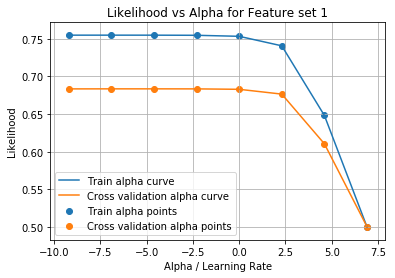

In [21]:


alpha_param_range=[0.0001,0.001,0.01,0.1,1,10,100,1000]

train_auc, cv_auc = find_Best_Alpha(X_tr_set1, y_train, X_cv_set1, y_cv, alpha_param_range)

plotting_Train_CV_Auc_curve(alpha_param_range, train_auc, cv_auc, 'Likelihood vs Alpha for Feature set 1')

### Choosing the best alpha from the above plot for feature set 1

In [22]:
#Choosing the best alpha from the above plot
best_alpha_set1 = 100

classifier = MultinomialNB(alpha = best_alpha_set1)
classifier.fit(X_tr_set1, y_train)
        
y_train_pred_set1 = classifier.predict_proba(X_tr_set1)[:,1]
y_test_pred_set1 = classifier.predict_proba(X_te_set1)[:,1]

### Finding AUC on train and test data for feature set 1

Train Auc for set 1
0.6481066099024949

 Test Auc for set 1
0.618421856203655


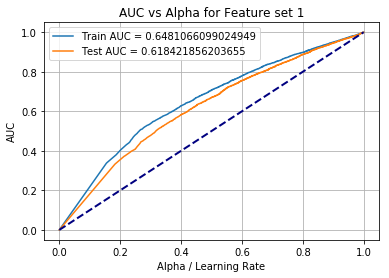

In [23]:
#Finding AUC on train and test data
train_auc_set1 = roc_auc_score(y_train, y_train_pred_set1)
print('Train Auc for set 1')
print(train_auc_set1)

test_auc_set1 = roc_auc_score(y_test, y_test_pred_set1)
print('\n Test Auc for set 1')
print(test_auc_set1)



#Finding FPR and TPR both on train and test
train_fpr_set1, train_tpr_set1, train_threshold_set1 = roc_curve(y_train, y_train_pred_set1)
test_fpr_set1, test_tpr_set1, test_threshold_set1 = roc_curve(y_test, y_test_pred_set1)


#Plotting AUC curve
plot_AUC(train_fpr_set1, train_tpr_set1, test_fpr_set1, test_tpr_set1, train_auc_set1, test_auc_set1,
         'AUC vs Alpha for Feature set 1')

### Finding the best threshold and confusion matrix on train and test probability for feature set 1

The maximum value of tpr*(1-fpr) 0.3798963340625611 for threshold 1.0

Train confusion matrix for set 1
[[ 2376  1219]
 [ 8015 10835]]


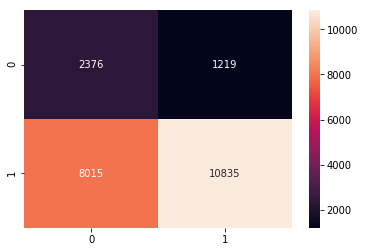

In [24]:
import seaborn as sns;

#Finding the best threshold
best_t = find_best_threshold(train_threshold_set1, train_fpr_set1, train_tpr_set1)

#Finding confusion matrix for train probability
train_confusion_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred_set1, best_t))
print("\nTrain confusion matrix for set 1")
print(train_confusion_matrix)

#Seaborn Heatmap representaion of Train confusion matrix
sns.heatmap(train_confusion_matrix, annot=True, fmt="d")


Test confusion matrix for set 1
[[1620 1022]
 [5963 7895]]


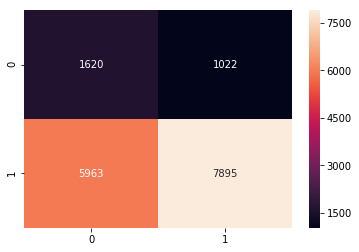

In [25]:
#Finding confusion matrix for test probability
test_confusion_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred_set1, best_t))
print("\nTest confusion matrix for set 1")
print(test_confusion_matrix)

#Seaborn Heatmap representaion of Test confusion matrix
sns.heatmap(test_confusion_matrix, annot=True, fmt="d")

### Finding Best Alpha in Features set 2

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 16.84it/s]


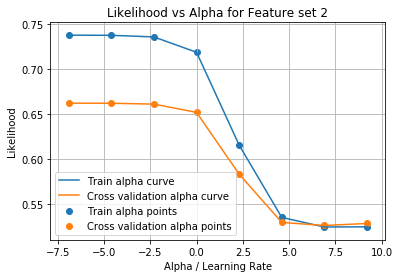

In [26]:
alpha_param_range=[0.001,0.01,0.1,1,10,100,1000,10000]

train_auc, cv_auc = find_Best_Alpha(X_tr_set2, y_train, X_cv_set2, y_cv, alpha_param_range)

plotting_Train_CV_Auc_curve(alpha_param_range, train_auc, cv_auc, 'Likelihood vs Alpha for Feature set 2')

### Choosing the best alpha from the above plot for feature set 2

In [27]:
#Choosing the best alpha from the above plot
best_alpha_set2 = 100

classifier = MultinomialNB(alpha = best_alpha_set2)
classifier.fit(X_tr_set2, y_train)
        
y_train_pred_set2 = classifier.predict_proba(X_tr_set2)[:,1]
y_test_pred_set2 = classifier.predict_proba(X_te_set2)[:,1]

### Finding AUC on train and test data for feature set 2

Train Auc for set 2
0.5354869974876689

 Test Auc for set 2
0.5272028367319046


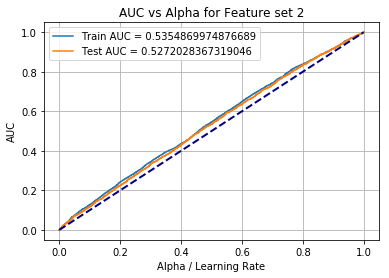

In [28]:
#Finding AUC on train and test data
train_auc_set2 = roc_auc_score(y_train, y_train_pred_set2)
print('Train Auc for set 2')
print(train_auc_set2)

test_auc_set2 = roc_auc_score(y_test, y_test_pred_set2)
print('\n Test Auc for set 2')
print(test_auc_set2)



#Finding FPR and TPR both on train and test
train_fpr_set2, train_tpr_set2, train_threshold_set2 = roc_curve(y_train, y_train_pred_set2)
test_fpr_set2, test_tpr_set2, test_threshold_set2 = roc_curve(y_test, y_test_pred_set2)


#Plotting AUC curve
plot_AUC(train_fpr_set2, train_tpr_set2, test_fpr_set2, test_tpr_set2, train_auc_set2, test_auc_set2, 
         'AUC vs Alpha for Feature set 2')

### Finding the best threshold and confusion matrix on train and test probability for feature set 2

The maximum value of tpr*(1-fpr) 0.2746601638733431 for threshold 1.0

Train confusion matrix for set 2
[[1862 1733]
 [8854 9996]]


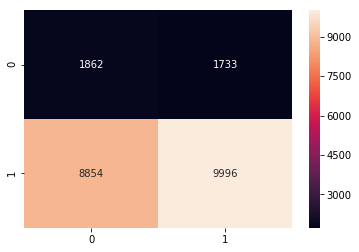

In [29]:
#Finding the best threshold
best_t = find_best_threshold(train_threshold_set2, train_fpr_set2, train_tpr_set2)

#Finding confusion matrix for train probability
train_confusion_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred_set2, best_t))
print("\nTrain confusion matrix for set 2")
print(train_confusion_matrix)

#Seaborn Heatmap representaion of Train confusion matrix
sns.heatmap(train_confusion_matrix, annot=True, fmt="d")


Test confusion matrix for set 2



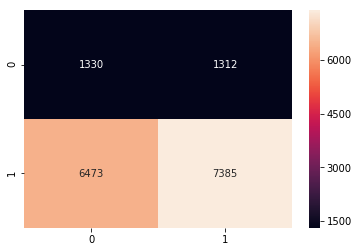

In [30]:
#Finding confusion matrix for test probability
test_confusion_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred_set2, best_t))
print("\nTest confusion matrix for set 2")
print()

#Seaborn Heatmap representaion of Train confusion matrix
sns.heatmap(test_confusion_matrix, annot=True, fmt="d")

### 4. Finding top 20 features from set 1

In [31]:
list_of_features = lst_state_features + lst_prefix_features + lst_grade_features + lst_categories_features \
                    + lst_subcategories_features + ['teacher_number_of_previously_posted_projects'] + ['price'] \
                    + lst_BOW_features

In [32]:
log_prob = classifierNB_set1.feature_log_prob_[0]

#Collecting top 20 absolute values of features from log_prob
#top_20_log_prob = sorted([abs(x) for x in log_prob], reverse=True)[:20]

#Collecting indices of top 20 features
#indices = [idx for idx, prob in enumerate(log_prob)  if abs(prob) in top_20_log_prob]

indices = np.array(log_prob).argsort()[:20]

#print(indices)

In [33]:
print('Top 20 features using absolute values of feature_log_prob_ from feature Set 1 \n')
print(np.array(list_of_features)[indices])

Top 20 features using absolute values of feature_log_prob_ from feature Set 1 

['dr' 'nd' 'reading grade' 'care_hunger' 'care_hunger' 'graphing'
 'reading grade level' 'vt' 'warmth' 'the wobble' 'wy' 'warmth' 'sd'
 'day ready learn' 'color printer' 'stools allow' 'wobble cushions'
 'day class' 'ri' 'responses']


### 5. Summarized Result

In [34]:
#present data in table python : http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]

x.add_row(["BOW", 'Naive Bayes', best_alpha_set1, test_auc_set1])
x.add_row(["TFIDF", 'Naive Bayes', best_alpha_set2, test_auc_set2])

In [35]:
print(x)

+------------+-------------+-----------------+--------------------+
| Vectorizer |    Model    | Hyper parameter |        AUC         |
+------------+-------------+-----------------+--------------------+
|    BOW     | Naive Bayes |       100       | 0.618421856203655  |
|   TFIDF    | Naive Bayes |       100       | 0.5272028367319046 |
+------------+-------------+-----------------+--------------------+


In [36]:
#Please give the feedback